Imports

In [12]:
from qiskit import *
from numpy import pi
import numpy as np

#Tensorflow library. Used to implement machine learning models
import tensorflow as tf
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
# |GHZ> 'circuit'
qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

circuit.h(qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[2])
circuit.measure(0, 0)
circuit.measure(1, 1)
circuit.measure(2, 2)
print(circuit)

     ┌───┐             ┌─┐   
q_0: ┤ H ├──■────■─────┤M├───
     └───┘┌─┴─┐  │  ┌─┐└╥┘   
q_1: ─────┤ X ├──┼──┤M├─╫────
          └───┘┌─┴─┐└╥┘ ║ ┌─┐
q_2: ──────────┤ X ├─╫──╫─┤M├
               └───┘ ║  ║ └╥┘
c: 3/════════════════╩══╩══╩═
                     1  0  2 


In [23]:
# w-state 'circuit_w' 

qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuit_w = QuantumCircuit(qreg_q, creg_c)

circuit_w.reset(qreg_q[0])
circuit_w.reset(qreg_q[1])
circuit_w.reset(qreg_q[2])
circuit_w.ry(1.9106332362490184, qreg_q[0])
circuit_w.cu(pi/2, pi/2, pi/2, pi/2, qreg_q[0], qreg_q[1])
circuit_w.cx(qreg_q[1], qreg_q[2])
circuit_w.cx(qreg_q[0], qreg_q[1])
circuit_w.x(qreg_q[0])
circuit_w.measure(qreg_q[0], creg_c[0])
circuit_w.measure(qreg_q[1], creg_c[1])
circuit_w.measure(qreg_q[2], creg_c[2])
print(circuit_w)

          ┌────────────┐                                ┌───┐┌─┐
q_0: ─|0>─┤ RY(1.9106) ├──────────■──────────────────■──┤ X ├┤M├
          └────────────┘┌─────────┴──────────┐     ┌─┴─┐└┬─┬┘└╥┘
q_1: ─|0>───────────────┤ U(π/2,π/2,π/2,π/2) ├──■──┤ X ├─┤M├──╫─
                        └────────────────────┘┌─┴─┐└┬─┬┘ └╥┘  ║ 
q_2: ─|0>─────────────────────────────────────┤ X ├─┤M├───╫───╫─
                                              └───┘ └╥┘   ║   ║ 
c: 3/════════════════════════════════════════════════╩════╩═══╩═
                                                     2    1   0 


In [24]:
#normalize data
def normalize(mem):
    list_ = []
    for num in mem:
        list_.append([int(numeric_string) for numeric_string in list(num)])
    return list_

# function to create datasource
def create_datasource(circ):
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(circ, backend_sim, shots=1024, memory=True)
    result_sim = job_sim.result()
 
    counts = result_sim.get_counts(circ)
    print(counts)
    memory = result_sim.get_memory()
    # save in test.csv
    #numpy.savetxt("test.csv", memory, delimiter=",", header='test',fmt='%s')
    return memory

In [46]:
# select circuit 
# raw_data = create_datasource(circuit)
raw_data = create_datasource(circuit_w)
datasource = normalize(raw_data)
# print(datasource)


{'010': 344, '100': 335, '001': 345}


In [53]:
nqbits = 3
hiddenUnits = 1
visibleUnits = nqbits # number of bits

#initialize neurons
vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32) #Visual Layer
hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32) #Hidden Layer
W = tf.Variable(tf.zeros([visibleUnits, hiddenUnits]), tf.float32) # Pesos entre las neuronas

v0 = tf.zeros([visibleUnits], tf.float32)

In [54]:
#useful functions
#Phase 1: Input Processing
#defining a function to return only the generated hidden states 
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)  #probabilities of the hidden units
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) #sample_h_given_X
    return h0_state

#printing output of zeros input
h0 = hidden_layer(v0, W, hb)

def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) #sample_v_given_h
    return v1_state[0]


v1 = reconstructed_output(h0, W, vb)

In [55]:
# error function
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))
err = tf.reduce_mean(tf.square(v0 - v1))
print("error" , err.numpy())

error 0.33333334


In [56]:
epochs = 5
batchsize = 200
errors = []
weights = []
K=1
alpha = 0.1

#creating datasets
train_ds = \
    tf.data.Dataset.from_tensor_slices((np.float32(datasource))).batch(batchsize)

In [57]:
v0_state=v0
for epoch in range(epochs):
    batch_number = 0
    for batch_x in train_ds:
        for i_sample in range(len(batch_x)):           
            for k in range(K):
                v0_state = batch_x[i_sample]
                h0_state = hidden_layer(v0_state, W, hb)
                v1_state = reconstructed_output(h0_state, W, vb)
                h1_state = hidden_layer(v1_state, W, hb)

                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W

                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0) 

                v0_state = v1_state
            
            if i_sample == len(batch_x)-1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W)
                print ( 'Epoch: %d' % (epoch + 1), 
                       "batch #: %i " % batch_number, "of %i" % (len(datasource)/batchsize)                        ,
                       "sample #: %i" % i_sample,
                       'reconstruction error: %f' % err)
        batch_number += 1



Epoch: 1 batch #: 0  of 5 sample #: 199 reconstruction error: 0.000000
Epoch: 1 batch #: 1  of 5 sample #: 199 reconstruction error: 0.666667
Epoch: 1 batch #: 2  of 5 sample #: 199 reconstruction error: 0.333333
Epoch: 1 batch #: 3  of 5 sample #: 199 reconstruction error: 0.333333
Epoch: 1 batch #: 4  of 5 sample #: 199 reconstruction error: 0.666667
Epoch: 1 batch #: 5  of 5 sample #: 23 reconstruction error: 0.333333
Epoch: 2 batch #: 0  of 5 sample #: 199 reconstruction error: 0.666667
Epoch: 2 batch #: 1  of 5 sample #: 199 reconstruction error: 0.666667
Epoch: 2 batch #: 2  of 5 sample #: 199 reconstruction error: 0.000000
Epoch: 2 batch #: 3  of 5 sample #: 199 reconstruction error: 0.333333
Epoch: 2 batch #: 4  of 5 sample #: 199 reconstruction error: 0.333333
Epoch: 2 batch #: 5  of 5 sample #: 23 reconstruction error: 0.666667
Epoch: 3 batch #: 0  of 5 sample #: 199 reconstruction error: 0.666667
Epoch: 3 batch #: 1  of 5 sample #: 199 reconstruction error: 0.666667
Epoch: 3

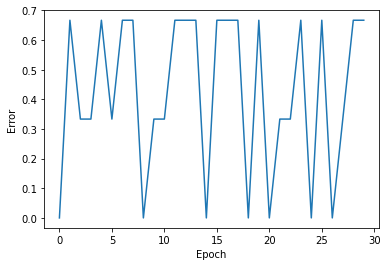

In [58]:
#plot 
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()